# Movie Recommendations

## Background

   When I first found out about the Netflix Prize competition in 2009, I was intrigued by the notion of building some sort of recommendation system using data. At that time, I was still an undergraduate student majoring in mathematics. I took some statistics class to better understand the theory behind the winner of the recommendation system, but I did not have the capability of writing any sort of computer code in any languages.
   
   Fast forward to today, the advancement of Python language and its numerous libraries enable me to implement my theoretical statistical knowledge to create a recommendation system. There are numerous topics that I can create a recommendation system for, but for this project I choose movies because there are so many tutorials and different means to do it. That way, I am able to learn many different techniques to apply for different topics in the future. Also, watching movies is one of my hobbies.
   
   Even though the movie recommendation system employed by various streaming platforms has been in mature stage, I believe that there is still room for improvement. There is one particular thing that bothers me when I search for a movie to watch, where the recommendations are too heavily influenced by the previous movies that I watched. Once in a while, I would like to watch a movie that is not in the same genre as the previous ones. 

## Outline

1. Download the data from https://grouplens.org/datasets/movielens/. I will choose the “MovieLens 10M Dataset”
2. Perform Exploratory Data Analysis (EDA) to check the integrity of the data.
3. Perform cross validation methods to choose which explanatory variables to be used
4. Separate the data into train and test set
5. Use either Memory-Based Collaborative Filtering based system or Model-based Collaborative Filtering system
6. Check the RMSE to see which one perform better

## Data Source

For this project, many tutorials recommend using Movielens database. They have accumulated 25 million movie ratings for 62,000 movies by 162,000 users. That is a lot of data especially for this project. Fortunately, the data can be easily downloaded from the website.

To start the project, I will use the 10 million movie ratings instead of the whole 25 million movie ratings.

## Import Library 

In [86]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## Import Data 

In [5]:
movie_titles = pd.read_csv('movies.dat', sep='::', header=None, names=['movieId', 'title', 'genres'])
movie_titles['genres'] = movie_titles['genres'].map(lambda x: x.replace('|',' '))
movie_titles.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
df = pd.read_csv('ratings.dat', sep='::', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
df.head()

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [7]:
tags = pd.read_csv('tags.dat', sep='::', header=None, names=['userId', 'movieId', 'tag', 'timestamp'])
tags.head()

,userId,movieId,tag,timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835


In [8]:
df_f = df.groupby('userId').filter(lambda x: len(x) >= 55)

## Data Cleaning 

### Check Missing Values 

In [9]:
movie_titles.isnull().values.any()

False

In [10]:
df.isnull().values.any()

False

In [91]:
df['rating'].dtype

dtype('float64')

In [11]:
tags.isnull().values.any()

True

The movies and ratings have no null value but tags have null values. In order to clean the data, I will replace the missing values with blank ("")

In [12]:
tags.fillna("", inplace=True)

In [13]:
tags.isnull().values.any()

False

In [14]:
movie_titles.describe()

,movieId
count,10681.000000
mean,13120.523546
std,17808.849139
min,1.000000
25%,2755.000000
50%,5436.000000
75%,8713.000000
max,65133.000000


In [15]:
df.describe()

,userId,movieId,rating,timestamp
count,1.000005e+07,1.000005e+07,1.000005e+07,1.000005e+07
mean,3.586986e+04,4.120291e+03,3.512422e+00,1.032606e+09
std,2.058534e+04,8.938402e+03,1.060418e+00,1.159640e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,1.812300e+04,6.480000e+02,3.000000e+00,9.467659e+08
50%,3.574050e+04,1.834000e+03,4.000000e+00,1.035476e+09
75%,5.360800e+04,3.624000e+03,4.000000e+00,1.126749e+09
max,7.156700e+04,6.513300e+04,5.000000e+00,1.231132e+09


In [16]:
tags.describe()

,userId,movieId,timestamp
count,95580.000000,95580.000000,9.558000e+04
mean,33963.364187,12511.053526,1.176687e+09
std,20916.217229,17534.965446,2.779340e+07
min,15.000000,1.000000,1.135313e+09
25%,16766.000000,1645.000000,1.151067e+09
50%,31175.000000,4308.000000,1.174660e+09
75%,51372.000000,8641.000000,1.197917e+09
max,71556.000000,65130.000000,1.231129e+09


We can see that there are 10,681 movie titles with 10 million user reviews. Movielens have 15 million more user reviews that can be used for testing purposes.

The tags dataset have 95,580 tags that can be used for memory-based methods in the Machine Learning section.

## Combine the Dataset 

Since the movies and ratings dataset are in different dataframes, I want to combine it into one dataframe.

In [17]:
df = pd.merge(df, movie_titles, on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,122,5.0,838985046,Boomerang (1992),Comedy Romance
1,139,122,3.0,974302621,Boomerang (1992),Comedy Romance
2,149,122,2.5,1112342322,Boomerang (1992),Comedy Romance
3,182,122,3.0,943458784,Boomerang (1992),Comedy Romance
4,215,122,4.5,1102493547,Boomerang (1992),Comedy Romance


In [18]:
df['year'] = df['title'].str[-5:-1]
df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,122,5.0,838985046,Boomerang (1992),Comedy Romance,1992
1,139,122,3.0,974302621,Boomerang (1992),Comedy Romance,1992
2,149,122,2.5,1112342322,Boomerang (1992),Comedy Romance,1992
3,182,122,3.0,943458784,Boomerang (1992),Comedy Romance,1992
4,215,122,4.5,1102493547,Boomerang (1992),Comedy Romance,1992


## Exploratory Data Analysis (EDA) 

### By Title 

In [19]:
ratings_by_title = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings_by_title.head()

,rating
title,
"""Great Performances"" Cats (1998)",3.583333
'Round Midnight (1986),3.720000
'Til There Was You (1997),2.837748
"'burbs, The (1989)",2.969415
'night Mother (1986),3.450237


In [20]:
ratings_by_title['no_of_ratings'] = df.groupby('title')['rating'].count()
ratings_by_title.head()

,rating,no_of_ratings
title,,
"""Great Performances"" Cats (1998)",3.583333,6
'Round Midnight (1986),3.720000,50
'Til There Was You (1997),2.837748,302
"'burbs, The (1989)",2.969415,1504
'night Mother (1986),3.450237,211


In [21]:
ratings_by_title.describe()

,rating,no_of_ratings
count,10676.000000,10676.000000
mean,3.191979,936.685463
std,0.566996,2487.431504
min,0.500000,1.000000
25%,2.847826,34.000000
50%,3.265452,135.000000
75%,3.608708,626.250000
max,5.000000,34864.000000


In [22]:
ratings_by_title.sort_values('no_of_ratings', ascending=False)

,rating,no_of_ratings
title,,
Pulp Fiction (1994),4.157426,34864
Forrest Gump (1994),4.013582,34457
"Silence of the Lambs, The (1991)",4.204200,33668
Jurassic Park (1993),3.661564,32631
"Shawshank Redemption, The (1994)",4.457238,31126
...,...,...
Down and Derby (2005),3.500000,1
Quiet City (2007),3.500000,1
Double Dynamite (1951),2.000000,1


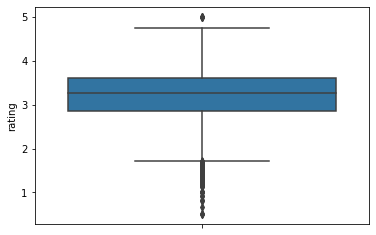

In [23]:
sns.boxplot(y=ratings_by_title['rating'])

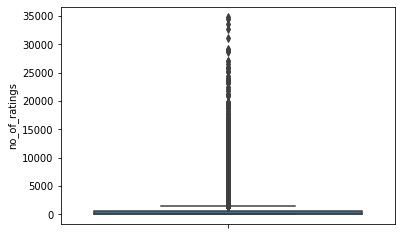

In [24]:
sns.boxplot(y=ratings_by_title['no_of_ratings'])

Text(0, 0.5, 'Number of Ratings')

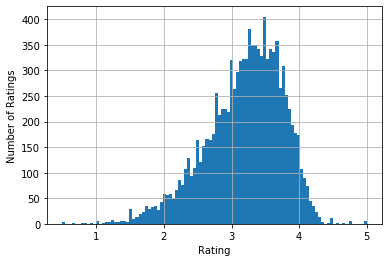

In [93]:
_ = ratings_by_title['rating'].hist(bins=100)
_.set_xlabel("Rating")
_.set_ylabel("Number of Ratings")

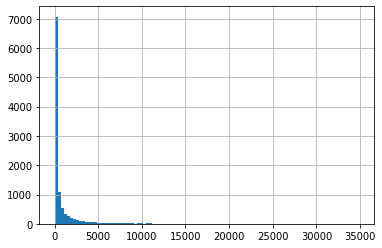

In [26]:
_ = ratings_by_title['no_of_ratings'].hist(bins=100)

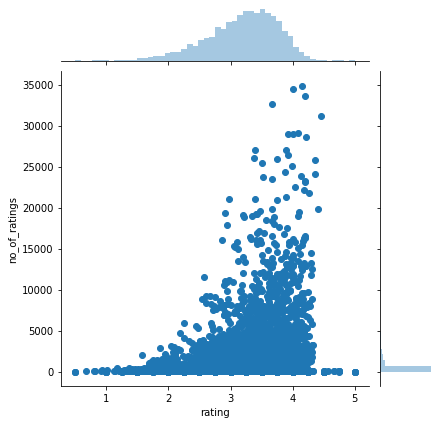

In [27]:
_ = sns.jointplot(x='rating', y='no_of_ratings', data=ratings_by_title)

I summarize the ratings for each movie's title and check the statistics of the ratings  and the number of the reviews per movie.

Here are the summary of findings:
- there are 10,676 different movie titles in the dataset
- the ratings range from 0.5 to 5 with mean of 3.19 and standard deviation of 0.567
- on average, there are 936 reviews per movie with standard deviation of 2,487.43
- the movie with most rating is Pulp Fiction (2004) with 34,864 reviews and rating of 4.15

### By Year

In [95]:
ratings_by_year = pd.DataFrame(df.groupby('year')['rating'].mean())
ratings_by_year.head(-1)

,rating
year,
1915,3.248768
1916,3.767327
1917,3.805556
1918,3.646341
1919,3.308743
...,...
2003,3.458140
2004,3.531266
2005,3.479449


In [29]:
ratings_by_year['no_of_ratings'] = df.groupby('year')['rating'].count()
ratings_by_year.head()

,rating,no_of_ratings
year,,
1915,3.248768,203
1916,3.767327,101
1917,3.805556,36
1918,3.646341,82
1919,3.308743,183


In [30]:
ratings_by_year.describe()

,rating,no_of_ratings
count,94.000000,94.000000
mean,3.720791,106383.553191
std,0.210645,172558.882603
min,3.248768,36.000000
25%,3.510599,8494.000000
50%,3.748273,30116.000000
75%,3.903301,116327.250000
max,4.054036,874436.000000


In [31]:
ratings_by_year.sort_values('no_of_ratings', ascending=False)

,rating,no_of_ratings
year,,
1995,3.442817,874436
1994,3.472097,746042
1996,3.360754,659425
1999,3.453832,543990
1993,3.496386,534899
...,...,...
1915,3.248768,203
1919,3.308743,183
1916,3.767327,101


In [32]:
ratings_by_year.sort_values('rating', ascending=False)

,rating,no_of_ratings
year,,
1946,4.054036,18719
1934,4.051894,6600
1942,4.043820,22353
1931,4.025816,8483
1941,4.013690,26589
...,...,...
2000,3.394061,425218
1997,3.364059,477463
1996,3.360754,659425


I summarize the ratings for each movie's title and check the statistics of the ratings  and the number of the reviews per movie.

Here are the summary of findings:
- the ratings range from 0.5 to 5 with mean of 3.72 and standard deviation of 0.211
- on average, there are 106,383.55 reviews per year with standard deviation of 172,558.88
- the year with most rating is 1995 with 874,436 reviews and rating of 3.44
- the year with the highest rating is 1946 with 18,719 reviews and rating of 4.05

## Inferential Statistics 

From the ratings data, we see that many movies have less ratings compared to the others. I want to break the data into 2 based on movie titles to test if movies with less reviews will tend to have the same average with movies with more reviews. 

In [49]:
ratings_less_100 = ratings_by_title[ratings_by_title['no_of_ratings'] <= 100]
ratings_less_100.head()

,rating,no_of_ratings
title,,
"""Great Performances"" Cats (1998)",3.583333,6
'Round Midnight (1986),3.720000,50
...All the Marbles (a.k.a. The California Dolls) (1981),2.217391,23
...And God Created Woman (Et Dieu... crÃ©a la femme) (1956),3.085526,76
...And God Spoke (1993),3.282609,23


In [50]:
ratings_less_100.describe()

,rating,no_of_ratings
count,4779.000000,4779.000000
mean,3.068150,35.577945
std,0.566654,27.244723
min,0.500000,1.000000
25%,2.740000,12.000000
50%,3.150000,30.000000
75%,3.469223,54.000000
max,5.000000,100.000000


In [51]:
ratings_more_100 = ratings_by_title[ratings_by_title['no_of_ratings'] > 100]
ratings_more_100.head()

,rating,no_of_ratings
title,,
'Til There Was You (1997),2.837748,302
"'burbs, The (1989)",2.969415,1504
'night Mother (1986),3.450237,211
*batteries not included (1987),3.153144,493
...And Justice for All (1979),3.652709,609


In [52]:
ratings_more_100.describe()

,rating,no_of_ratings
count,5897.000000,5897.000000
mean,3.292332,1666.953875
std,0.547131,3163.905059
min,0.923611,101.000000
25%,2.955955,218.000000
50%,3.381759,521.000000
75%,3.699683,1616.000000
max,4.457238,34864.000000


Even though the breakdown is not exactly 50/50 but I believe that this is sufficient to test my hypothesis.

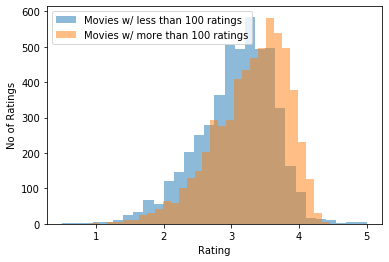

In [64]:
_ = plt.hist(ratings_less_100['rating'], bins=30, alpha=0.5, label='Movies w/ less than 100 ratings')
_ = plt.hist(ratings_more_100['rating'], bins=30, alpha=0.5, label='Movies w/ more than 100 ratings')
_ = plt.xlabel('Rating')
_ = plt.ylabel('No of Ratings')
_ = plt.legend()

We see that the movies with more ratings is slightly have a higher ratings than movies with less ratings.

In [88]:
ttest_ind(ratings_more_100['rating'], ratings_less_100['rating'])

Ttest_indResult(statistic=20.71761341603218, pvalue=1.6386528009915296e-93)

In [89]:
ttest_ind(ratings_more_100['rating'], ratings_less_100['rating'], equal_var = False)

Ttest_indResult(statistic=20.64170713775535, pvalue=9.490857787821262e-93)

When we use the t-test to confirm it, both actually have identical average values.

In [65]:
ratings_by_year.sort_values('year', ascending=False)

,rating,no_of_ratings
year,,
2008,3.458922,29675
2007,3.528900,84083
2006,3.535545,115275
2005,3.479449,142958
2004,3.531266,227531
...,...,...
1919,3.308743,183
1918,3.646341,82
1917,3.805556,36


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002231A316A88>,
      dtype=object)

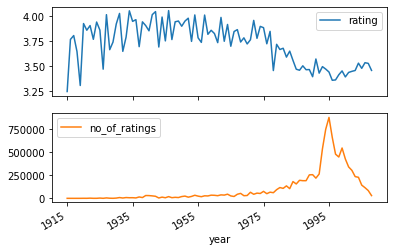

In [85]:
ratings_by_year.plot.line(subplots=True)

## Recommendation System 

### Simple Correlation 

In [36]:
movie_user = df.pivot_table(index='userId', columns='title', values='rating')
movie_user.head()

title,"""Great Performances"" Cats (1998)",'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),*batteries not included (1987),...All the Marbles (a.k.a. The California Dolls) (1981),...And God Created Woman (Et Dieu... crÃ©a la femme) (1956),...And God Spoke (1993),...And Justice for All (1979),...,Zorba the Greek (Alexis Zorbas) (1964),"Zorro, the Gay Blade (1981)",Zulu (1964),Zus & Zo (2001),[Rec] (2007),eXistenZ (1999),ffolks (a.k.a. North Sea Hijack) (1980),loudQUIETloud: A Film About the Pixies (2006),xXx: State of the Union (2005),"Ã‚ge d'or, L' (1930)"
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
search_title = [col for col in movie_user.columns if 'Star' in col]
search_title

['Babylon 5: The Legend of the Rangers: To Live and Die in Starlight (2002)',
 'Battle Beyond the Stars (1980)',
 'Beyond the Stars (1989)',
 'Brenda Starr (1989)',
 'Dark Star (1974)',
 'Dickie Roberts: Former Child Star (2003)',
 'Even Dwarfs Started Small (Auch Zwerge haben klein angefangen) (1971)',
 'Evening Star, The (1996)',
 'Fist of the North Star (1995)',
 'Flaming Star (1960)',
 'Frankie Starlight (1995)',
 "I'm Starting From Three (Ricomincio da Tre) (1981)",
 "It All Starts Today (Ã‡a commence aujourd'hui) (1999)",
 'Last Starfighter, The (1984)',
 'Lone Star (1996)',
 'Night of the Shooting Stars (La Notte di San Lorenzo) (1982)',
 'Niko & The Way to the Stars (Niko - LentÃ¤jÃ¤n poika) (2008)',
 'Rock Star (2001)',
 'Star 80 (1983)',
 'Star Chamber, The (1983)',
 'Star Is Born, A (1937)',
 'Star Kid (1997)',
 "Star Maker, The (L'Uomo delle stelle) (1995)",
 'Star Maps (1997)',
 'Star Trek II: The Wrath of Khan (1982)',
 'Star Trek III: The Search for Spock (1984)',
 'Star

In [38]:
correlations = movie_user.corrwith(movie_user['Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977)'])
correlations.head()

title
"Great Performances" Cats (1998)    0.909124
'Round Midnight (1986)              0.402496
'Til There Was You (1997)           0.120703
'burbs, The (1989)                  0.054499
'night Mother (1986)                0.196266
dtype: float64

In [39]:
recommendation = pd.DataFrame(correlations*100, columns=['Correlation'])
recommendation.dropna(inplace=True)
recommendation = recommendation.join(ratings_by_title['no_of_ratings'])
recommendation.head()

,Correlation,no_of_ratings
title,,
"""Great Performances"" Cats (1998)",90.912377,6
'Round Midnight (1986),40.249603,50
'Til There Was You (1997),12.070264,302
"'burbs, The (1989)",5.449889,1504
'night Mother (1986),19.626576,211


In [40]:
recc = recommendation[recommendation['no_of_ratings']>100].sort_values('Correlation', ascending=False).reset_index()

In [41]:
recc = recc.merge(movie_titles, on='title', how='left')
recc.head(11)

,title,Correlation,no_of_ratings,movieId,genres
0,Star Wars: Episode IV - A New Hope (a.k.a. Sta...,100.000000,28566,260,Action Adventure Sci-Fi
1,Star Wars: Episode V - The Empire Strikes Back...,72.164990,23091,1196,Action Adventure Sci-Fi
2,Star Wars: Episode VI - Return of the Jedi (1983),66.312501,25098,1210,Action Adventure Sci-Fi
3,Beyond Silence (Jenseits der Stille) (1996),48.432453,106,1893,Drama
4,Raiders of the Lost Ark (Indiana Jones and the...,46.240733,21803,1198,Action Adventure
5,Futurama: Bender's Game (2008),46.023348,141,62956,Animation Comedy Sci-Fi
6,My Name Is Nobody (Il Mio nome Ã¨ Nessuno) (1973),45.841934,119,26294,Comedy Western
7,"Apartment, The (L'Appartement) (1996)",43.308614,132,6789,Drama Mystery Romance
8,"Hairdresser's Husband, The (Mari de la coiffeu...",43.285454,138,8270,Comedy Drama Romance
9,Blackboard Jungle (1955),42.578024,163,8451,Drama


By using a simple correlation, we calculated the correlation between a given movie (in this example the original Star Wars) and list other movies that have the highest correlation with the given movie.

We can see that the first 2 recommended movies are the 2 next episodes of Star Wars. I am quite surprised that it does not recommend all the Star Wars series. I myself is a huge fan of Star Wars and only have seen one other movie (Indiana Jones) from this recommendation system.

I feel like this is a good start for a recommendation system but it is enough. In the next part, we will use different methods.

### Memory-based Methods

In [140]:
mixed = pd.merge(movie_titles, tags, on='movieId', how='left')
mixed.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1751.0,Pixar,1.137525e+09
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,2030.0,Pixar,1.162990e+09
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,2346.0,Pixar,1.216146e+09
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,2456.0,animation,1.163101e+09
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,2456.0,Pixar,1.163101e+09


In [141]:
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movie_titles, mixed, on='movieId', how='left')
Final['metadata'] = Final[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)
Final.head()

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Pixar Pixar Pixar animation Pixar animated fun...,Pixar Pixar Pixar animation Pixar animated fun...
1,2,Jumanji (1995),Adventure Children Fantasy,For children game animals Joe Johnston Robin W...,For children game animals Joe Johnston Robin W...
2,3,Grumpier Old Men (1995),Comedy Romance,Funniest Movies comedinha de velhinhos engraÃƒ...,Funniest Movies comedinha de velhinhos engraÃƒ...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,girl movie,girl movie Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,steve martin pregnancy remake steve martin fam...,steve martin pregnancy remake steve martin fam...


In [142]:
Final.shape

(10681, 5)

In [143]:
Final_ = Final[Final['movieId'] != 25942]
Final_ = Final_[Final_['movieId'] != 60566]
Final_ = Final_[Final_['movieId'] != 62669]
Final_ = Final_[Final_['movieId'] != 64959]

In [144]:
Final.loc[Final['movieId'] == 25942, 'title']

8391    Louisiana Story (1948)
Name: title, dtype: object

In [145]:
Final.loc[Final['movieId'] == 60566, 'title']

10360    Just Another Love Story (KÃ¦rlighed pÃ¥ film) ...
Name: title, dtype: object

In [146]:
Final.loc[Final['movieId'] == 62669, 'title']

10510    Black River (Kuroi kawa) (1957)
Name: title, dtype: object

In [147]:
Final.loc[Final['movieId'] == 64959, 'title']

10661    Divide and Conquer (Why We Fight, 3) (1943)
Name: title, dtype: object

In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
tfidf_df.shape

(10681, 11656)

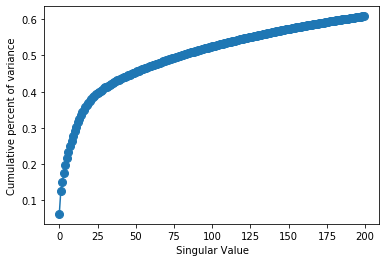

In [149]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)

explained = svd.explained_variance_ratio_.cumsum()
_ = plt.plot(explained, '.-', ms = 16)
_ = plt.xlabel(' Singular Value')
_ = plt.ylabel('Cumulative percent of variance')

In [150]:
latent_matrix_df = pd.DataFrame(latent_matrix, index=Final.title.tolist())

In [151]:
latent_matrix_df_ = latent_matrix_df[latent_matrix_df.index != 'Louisiana Story (1948)']
latent_matrix_df_ = latent_matrix_df_[latent_matrix_df_.index != 'Just Another Love Story (KÃ¦rlighed pÃ¥ film) (2007)']
latent_matrix_df_ = latent_matrix_df_[latent_matrix_df_.index != 'Black River (Kuroi kawa) (1957)']
latent_matrix_df_ = latent_matrix_df_[latent_matrix_df_.index != 'Divide and Conquer (Why We Fight, 3) (1943)']

In [152]:
ratings_f1 = pd.merge(movie_titles['movieId'], df, on='movieId', how='right')
ratings_f2 = ratings_f1.pivot(index='movieId', columns='userId', values='rating').fillna(0)
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2.shape

(10677, 200)

In [153]:
#exp = pd.DataFrame(ratings_f2.index)

In [154]:
#exp.to_excel("test.xlsx")

In [155]:
Final_.shape

(10677, 5)

In [156]:
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=Final_.title.tolist())

In [160]:
from sklearn.metrics.pairwise import cosine_similarity

a1 = np.array(latent_matrix_df_.loc['Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977)']).reshape(1, -1)
a2 = np.array(latent_matrix_2_df.loc['Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977)']).reshape(1, -1)

score_1 = cosine_similarity(latent_matrix_df_, a1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a2).reshape(-1)

hybrid = ((score_1 + score_2) /2)

dictDf = {'content': score_1, 'collaborative': score_2, 'hybrid': hybrid}
similar = pd.DataFrame(dictDf, index = latent_matrix_df_.index)

In [163]:
similar.sort_values('hybrid', ascending=False, inplace=True)
similar.head(11)

,content,collaborative,hybrid
Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977),1.000000,1.000000,1.000000
Star Wars: Episode V - The Empire Strikes Back (1980),0.928173,0.816428,0.872301
Star Wars: Episode VI - Return of the Jedi (1983),0.930210,0.802906,0.866558
Star Wars: Episode I - The Phantom Menace (1999),0.861073,0.647685,0.754379
Alien (1979),0.828625,0.645439,0.737032
Aliens (1986),0.827119,0.619920,0.723519
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),0.628613,0.708514,0.668563
Star Wars: Episode II - Attack of the Clones (2002),0.803294,0.517743,0.660518
Star Trek II: The Wrath of Khan (1982),0.721322,0.562013,0.641668
2001: A Space Odyssey (1968),0.712196,0.556944,0.634570
